In [56]:
%load_ext autoreload
%autoreload 2

import geopandas as gpd
import pandas as pd
from pathlib import Path
from os import makedirs, listdir
import fiona
import matplotlib.pyplot as plt
import numpy as np

from pin_drop_sampling2.utils import (
    count_neighbors_in_radius, 
    sample_locations_with_pps,
    randomly_sample_rooftops)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
# Paths to files
INPUT_PATH = Path("../data/03_Output/Kilifi -- Kenya/00_utils_data")
PREPROCESSED_PATH = Path("../data/03_Output/Kilifi -- Kenya/01_filtered_shapes")
OUTPUT_PATH = Path("../data/03_Output/Kilifi -- Kenya/02_sampled_locations_and_rooftops")


# Load files / params
subcounties = listdir(PREPROCESSED_PATH)
merged_data = gpd.read_file(INPUT_PATH / "Kilifi_merged_sublocations.shp")

# Parameters
num_psus_per_subcounty = 10
rooftop_neighborhood_radius = 100
num_rooftops_per_sublocation = 10
np.random.seed(0)
random_seed = np.random.randint(0, 1000)
random_seed

684

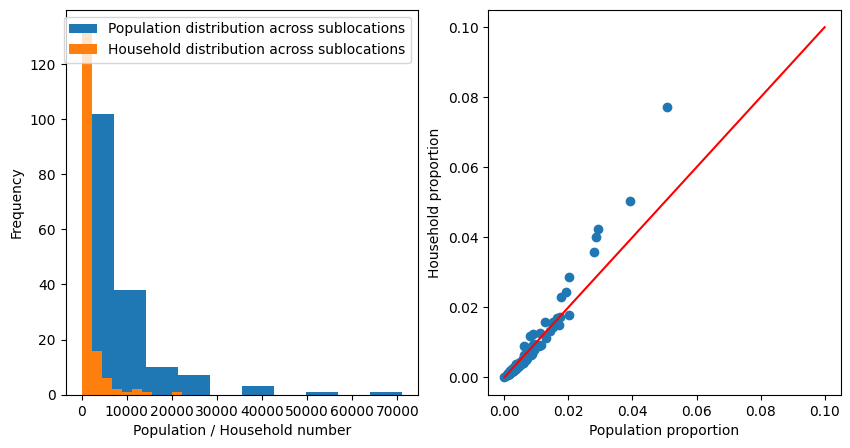

In [6]:
# Check distribution of population / households in Kilifi

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(merged_data['ind_total'], label="Population distribution across sublocations")
ax1.hist(merged_data['hh_total'], label="Household distribution across sublocations")
ax1.set_xlabel("Population / Household number")
ax1.set_ylabel("Frequency")
ax1.legend()

ax2.plot(merged_data['ind_total'] / merged_data['ind_total'].sum(), 
		 merged_data['hh_total'] / merged_data['hh_total'].sum(), 'o')
ax2.plot(np.linspace(0, .1, 100), np.linspace(0, .1, 100), 'r')
ax2.set_xlabel("Population proportion")
ax2.set_ylabel("Household proportion")

plt.show()

In [44]:
# For each subcounty sample 10 sublocations using PPS with replacement, and save
for subcounty in subcounties:
    sublocations = gpd.read_parquet(PREPROCESSED_PATH / subcounty / "all_sublocations.parquet")
    sublocation_names = sublocations.SLNAME.values
    sublocation_sizes = sublocations['ind_total'].values
    samples = sample_locations_with_pps(
        sublocation_names, 
        sublocation_sizes, 
        num_psus_per_subcounty,
        with_replacement=True,
        random_seed=random_seed)
    sampled_sublocations = sublocations.iloc[samples[1]]
    sampled_sublocations['pps_prob'] = samples[2]
    
    # Save the sampled sublocations
    makedirs(OUTPUT_PATH / subcounty, exist_ok=True)
    sampled_sublocations.to_parquet(OUTPUT_PATH / subcounty / "sampled_sublocations.parquet")



/Users/poornimaramesh/Library/Caches/pypoetry/virtualenvs/pin-drop-sampling2-RChTn2Ku-py3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/poornimaramesh/Library/Caches/pypoetry/virtualenvs/pin-drop-sampling2-RChTn2Ku-py3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/poornimaramesh/Library/Caches/pypoetry/vi

In [70]:
# For each sublocation, sample 10 rooftops
for subcounty in subcounties:
    print("\n", subcounty)
    # Load sampled sublocations and rooftops
    sampled_sublocations = gpd.read_parquet(OUTPUT_PATH / 
                                            subcounty / 
                                            "sampled_sublocations.parquet")

    for i, sublocation in enumerate(sampled_sublocations.SLNAME):
        sublocation = sublocation.replace("/", "-")
        sublocation_rooftops = gpd.read_parquet(PREPROCESSED_PATH / 
                                                subcounty / 
                                                f"{sublocation}_rooftops.parquet")
        
        num_neighbours = count_neighbors_in_radius(
            gpd.GeoDataFrame(sublocation_rooftops.drop(columns='geometry'), 
                             geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x, 
                                                         sublocation_rooftops.centroid.y),
                            crs=sublocation_rooftops.crs
                             ), 
            rooftop_neighborhood_radius)
        sublocation_rooftops['num_neighbours'] = num_neighbours

        # Sample 10 rooftops
        np.random.seed(random_seed + i*10)
        rooftop_random_seed = np.random.randint(0, 10000)
        rooftop_idx = randomly_sample_rooftops(
            num_neighbours, 
            num_rooftops_per_sublocation, 
            random_seed=rooftop_random_seed)
        sampled_rooftops = sublocation_rooftops.iloc[rooftop_idx]

        sampled_rooftops.to_parquet(OUTPUT_PATH / subcounty / f"{i+1}_{sublocation}_sampled_rooftops.parquet")
        print(f"{rooftop_random_seed} | {sublocation}: {sampled_rooftops.shape[0]}")



 Rabai Sub County
2651 | CHAURINGO: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc1

9069 | BUNI-CHISIMANI: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),


4591 | MAZERAS-MUGUMO PATSA: 10
4959 | KALIANGOMBE-JIMBA: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc1

1030 | MAZERAS-MUGUMO PATSA: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),


445 | BUNI-CHISIMANI: 10
5525 | BWAGAMOYO: 10
7493 | BWAGAMOYO: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc1

7870 | MBWAKA-KIKOMANI: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),


1352 | BUNI-CHISIMANI: 10

 Malindi Sub County
2651 | MAKOBENI: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc1

9069 | SHELLA: 10
4591 | GANDA: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc1

4959 | CENTRAL: 10
1030 | KAKUYUNI: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc1

445 | SHELLA: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),


5525 | SHELLA: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),


7493 | KIJIWETANGA: 10
7870 | MONGOTINI: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc1

1352 | SHELLA: 10

 Kilifi South Sub County
2651 | KURUWITU: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc1

9069 | SHIMO LA TEWA: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),


4591 | KANAMAI: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),


4959 | SHIMO LA TEWA: 10
1030 | KIDUTANI-MAWAMBA: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc1

445 | SHIMO LA TEWA: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),


5525 | KIJIPWA: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),


7493 | KIJIPWA: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),


7870 | VIPINGO: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),


1352 | SHIMO LA TEWA: 10

 Kilifi North Sub County
2651 | CHEMBE KIBABA MUCHE: 10
9069 | NGERENYA: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc1

4591 | MAVUENI-MAJAJANI: 10
4959 | ROKA: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc1

1030 | MKWAJUNI-MKOMANI: 10
445 | NGERENYA: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc1

5525 | MTONDIA-MAJAONI: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),


7493 | MNARANI: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),


7870 | WATAMU: 10
1352 | NGERENYA: 10

 Ganze Sub County
2651 | MALANGA: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc1

9069 | PAZIANI: 10
4591 | MADAMANI: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc1

4959 | MTSARA-WA-TSATSU: 10
1030 | MWAHERA: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc1

445 | MTSARA-WA-TSATSU: 10
5525 | MNAGONI: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc1

7493 | PALAKUMI-MIGUMOMIRI: 10
7870 | MAGOGONI: 10
1352 | PAZIANI: 10

 Magarini Sub County


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc1

2651 | KISIKI CHA WANGIRIAM: 10
9069 | NGOMENI: 10
4591 | MAMBRUI: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),


4959 | GONGONI: 10
1030 | BOMANI: 10
445 | SHOMELA: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc1

5525 | MARERENI: 10
7493 | FUNDISA: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc1

7870 | SABAKI: 10
1352 | SHOMELA: 10

 Kaloleni Sub County
2651 | MAKOMBOANI: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc1

9069 | KAWALA-KADZONZO: 10
4591 | KIBWABWANI: 10
4959 | NYALANI: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc1

1030 | KALOLENI-VISH.-TSAKA: 10
445 | MUNYENZENI: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc1

5525 | MARIAKANI-MITANGONI: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),


7493 | MARIAKANI-MITANGONI: 10
7870 | CHALANI-MIHINGONI: 10


/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sublocation_rooftops.centroid.y),
/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_12561/1700979264.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=gpd.points_from_xy(sublocation_rooftops.centroid.x,
/var/folders/mq/6zyh6j6j1wzc58dyc1

1352 | KAWALA-KADZONZO: 10
